In [1]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import skimage
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler
from torchvision import datasets
from torchvision import transforms as tr
from torchvision.io import read_image
from torchvision import models
from tqdm.notebook import tqdm

%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
data_folder = "./RGBaHa(26-03-23)"
images_folder = "RGBaHa"
table_file = "data.csv"
types_file = "types.csv"

In [4]:
target_column = "latin"

In [5]:
class TreeDataset(Dataset):
    def __init__(self, imgs_path, table_path, types_path):
        super().__init__()
        
        self.types = pd.read_csv(types_path, index_col=0)
        self.table = pd.read_csv(table_path, index_col=0, converters={"latin": lambda x: self.types.loc[x].type if x != "NA" else np.nan}).dropna()
        self.label_map = {label: i for i, label in enumerate(self.table.latin.unique())}
        self.table = self.table.replace({"latin": self.label_map})
        
        self.max_h, self.max_w = 0, 0
        self.channel_mean, self.channel_std = 0, 0
        self.depth_max = 0
        images = []
        
        for tree_id in self.table.treeID:
            file_path = os.path.join(imgs_path, f"treeID_{tree_id}.tiff")
            img_rgbd = skimage.io.imread(file_path)[:, :, [0, 1, 2, 4]].transpose(2, 0, 1)[None, :, :, :]
            self.max_h = max(self.max_h, img_rgbd.shape[2])
            self.max_w = max(self.max_w, img_rgbd.shape[3])
            images.append(torch.from_numpy(img_rgbd))
            self.depth_max = max(self.depth_max, img_rgbd[:, 3, :, :].max())
        
        padded_images = []
        for image in images:
            image[:, :3, :, :] /= 255.
            image[:, 3, :, :] /= self.depth_max
            img_h, img_w = image.shape[2:]
            h_pos = (self.max_h - img_h) // 2
            w_pos = (self.max_w - img_w) // 2
            padded = torch.zeros(1, 4, self.max_h, self.max_w)
            padded[:, :, h_pos: h_pos+img_h, w_pos: w_pos+img_w] = image
            padded_images.append(padded)            
            
            self.channel_mean += image.mean(dim=(0, 2, 3))
            self.channel_std += image.std(dim=(0, 2, 3))

        self.images = torch.cat(padded_images)
        self.channel_mean /= len(self.images)
        self.channel_std /= len(self.images)
        
    def __getitem__(self, index):
        x = self.images[index].type(torch.FloatTensor)
        y = torch.tensor(self.table.iloc[index].loc[target_column], dtype=torch.long)
        return x, y
    
    def __len__(self):
        return len(self.table)

In [6]:
class TreeDatasetFromSubset(Dataset):
    def __init__(self, subset, all_transform=None, rgb_transform=None):
        self.subset = subset
        self.all_transform = all_transform
        self.rgb_transform = rgb_transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.all_transform:
            x = self.all_transform(x)
        if self.rgb_transform:
            x[:3, :, :] = self.rgb_transform(x[:3, :, :])
        return x[:3, :, :], y

    def __len__(self):
        return len(self.subset)

In [7]:
data = TreeDataset(os.path.join(data_folder, images_folder), 
                   os.path.join(data_folder, table_file), 
                   os.path.join(data_folder, types_file))

In [8]:
train, val, test = random_split(data, [0.70, 0.20, 0.10])

In [9]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.1):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [10]:
all_transform = tr.Compose([
    tr.Normalize(data.channel_mean, data.channel_std),
    tr.RandomHorizontalFlip(),
    tr.RandomVerticalFlip(),
    tr.RandomAffine(degrees=180),
    # tr.RandomApply([AddGaussianNoise(),]),
])
rgb_transform = tr.Compose([
    # tr.RandomAutocontrast(),
    # tr.RandomAdjustSharpness(0.5),
])

prepare_transform = tr.Compose([
    tr.Normalize(data.channel_mean, data.channel_std),
])

In [11]:
train_dataset = TreeDatasetFromSubset(train, all_transform=all_transform, rgb_transform=rgb_transform)
val_dataset = TreeDatasetFromSubset(val, all_transform=prepare_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Targets:
tensor(4)


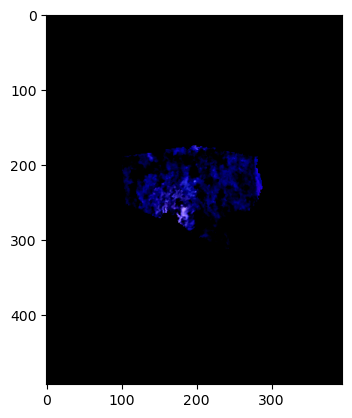

In [12]:
print("Targets:")
idx = np.random.randint(0, 100)
print(train_dataset[idx][1])
plt.imshow(train_dataset[idx][0].movedim(0, -1))
plt.show()

In [13]:
def make_weights_for_balanced_classes(data, indices=None):
    n_images = len(data.table)
    count_per_class = np.bincount(data.table.latin, minlength=len(data.table.latin.unique()))
    weight_per_class = (float(n_images) / count_per_class)
    weights = weight_per_class[data.table.latin]
    if indices:
        weights = weights[indices]
    return torch.tensor(weights)

In [14]:
BATCH_SIZE = 2

train_weights = make_weights_for_balanced_classes(train.dataset, train.indices)
train_sampler = WeightedRandomSampler(train_weights, len(train_weights))
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    sampler=train_sampler,
    drop_last=True,
)

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False,
)

all_loader = DataLoader(
    dataset=TreeDatasetFromSubset(data, prepare_transform),
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False,
)

In [15]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        stride = (2, 2) if in_channels != out_channels else (1, 1)

        self.shortcut = nn.Identity()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, (1, 1), stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        self.activation = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels, out_channels, (3, 3), stride, padding=(1, 1), bias=False)
        self.conv2 = nn.Conv2d(out_channels, out_channels, (3, 3), padding=(1, 1), bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        residual = self.shortcut(x)
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.activation(x)

        return x + residual


class ResNetLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.blocks = nn.Sequential(
            ResidualBlock(in_channels, out_channels),
            ResidualBlock(out_channels, out_channels)
        )
        
    def forward(self, x):
        x = self.blocks(x)
        return x

In [16]:
class ResNet18(nn.Module):
    def __init__(self, out_channels=32, layer_num=3, fc_hidden=128, in_channels=3, classes_num=len(data.label_map)):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, (3, 3), padding=(1, 1), bias=True)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()
        self.maxpool = nn.MaxPool2d((2, 2))
        self.layers = nn.Sequential(
            ResNetLayer(out_channels, out_channels),
            *[ResNetLayer(2**i * out_channels, 2**(i+1) * out_channels) for i in range(layer_num - 1)],
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        
        # predicting tree species
        self.fc_clf = nn.Sequential(
            nn.Linear(2**(layer_num - 1) * out_channels, fc_hidden),
            nn.BatchNorm1d(fc_hidden),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(fc_hidden, classes_num),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.maxpool(x)
        
        x = self.layers(x)
        
        x = self.avgpool(x)
        x = self.flatten(x)
        
        x_clf = self.fc_clf(x)
        return x_clf

In [17]:
import IPython


def train_loop(model, dataloader, loss_clf_fn, optimizer, step=0.05, history_loss=None, history_acc=None):
    out = display(IPython.display.Pretty('Learning...'), display_id=True)

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    train_acc = []
    train_loss = []
    percentage = 0
    
    for batch, (X, y_clf) in enumerate(tqdm(dataloader, leave=False, desc="Batch #")):
        torch.cuda.empty_cache()
        gc.collect()
        
        X = X.to(device)
        y_clf = y_clf.to(device)
        pred_clf = model(X)
        loss = loss_clf_fn(pred_clf, y_clf)
        train_acc.append((pred_clf.argmax(1) == y_clf).type(torch.float).mean().item())
        train_loss.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch / (num_batches - 1) >= percentage:
            percentage = int(batch / (num_batches - 1) / step) * step
            out.update(f'[{int(percentage * size)}/{size}] Batch NLL Loss: {loss.item():>8f}')
        
    if history_loss is not None:
        history_loss.append(np.mean(train_loss))
    if history_acc is not None:
        history_acc.append(np.mean(train_acc))

    return {'train_loss': np.mean(train_loss), 'train_acc': np.mean(train_acc)}


def test_loop(model, dataloader,  loss_clf_fn, history_loss=None, history_acc=None):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    val_acc = []
    val_loss = []
    correct = 0

    with torch.no_grad():
        for batch, (X, y_clf) in enumerate(tqdm(dataloader, leave=False, desc="Batch #")):
            torch.cuda.empty_cache()
            gc.collect()
        
            X = X.to(device)
            y_clf = y_clf.to(device)
            pred_clf = model(X)
            loss = loss_clf_fn(pred_clf, y_clf)
            val_acc.append((pred_clf.argmax(1) == y_clf).type(torch.float).mean().item())
            val_loss.append(loss.item())
            correct += (pred_clf.argmax(1) == y_clf).type(torch.float).sum().item()

        correct /= size
        total_loss = np.mean(val_loss)
        print(f"Validation accuracy: {(100*correct):>0.1f}%, Validation NLL Loss: {total_loss:>8f} \n")

    if history_loss is not None:
        history_loss.append(total_loss)
    if history_acc is not None:
        history_acc.append(correct)
    
    return {'val_loss': total_loss, 'val_acc': correct}

In [18]:
def plot_learning_process(train_loss, val_loss, title):
    
    fig = plt.figure(figsize=(12, 4))
    
    ax1 = plt.subplot(121)
    ax1.plot(np.arange(0, len(train_loss)) + 1, train_loss, label='train')
    ax1.plot(np.arange(0, len(val_loss)) + 1, val_loss, label='val')
    ax1.legend()
    ax1.grid()
    ax1.set_xlabel('epoch')
    ax1.set_ylabel(title.split()[0])
    ax1.set_title(title)
    
    fig.tight_layout()
    plt.show()

In [19]:
# train_label_counts = np.bincount(train.dataset.table.iloc[train.indices].latin.values, minlength=len(data.table.latin.unique()))
# train_label_weights = ((train_label_counts + 1e-5) / train_label_counts.sum()) **-0.5
# train_label_weights = torch.tensor(train_label_weights, dtype=torch.float, device=device)
# loss_clf = nn.NLLLoss(train_label_weights)

loss_clf = nn.NLLLoss()
epochs = 50

models_results = []
for chan in tqdm([8]):
    for layer_n in tqdm([3]):
        for fc_hidden in tqdm([512]):
            # net = ResNet18(out_channels=chan, layer_num=layer_n, fc_hidden=fc_hidden).to(device)
            # net = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14').to(device)
            net = models.efficientnet_v2_s(weights="DEFAULT")
            # for param in net.parameters():
            #     net.requires_grad = False
            net.classifier = nn.Sequential(
                nn.Flatten(),
                nn.Linear(1280, len(data.label_map)),
                nn.LogSoftmax(dim=1),
            )
            net.to(device)
            optimizer = torch.optim.Adam(net.parameters(), lr=2e-4)
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=5, min_lr=1e-7)

            train_acc, train_loss = [], []
            val_acc, val_loss = [], []

            models_results.append({"first_out_channel": chan, "layer_num": layer_n, "fc_hidden": fc_hidden})
            for epoch in range(epochs):
                print(f"Epoch {epoch+1}")
                print("-------------------------------")
                train_loop(net, train_dataloader, loss_clf, optimizer, history_loss=train_loss, history_acc=train_acc)
                test_loop(net, val_dataloader, loss_clf, history_loss=val_loss, history_acc=val_acc)
                scheduler.step(val_loss[-1])
            
            models_results[-1][f"train_{target_column}_acc"] = train_acc
            models_results[-1][f"train_{target_column}_loss"] = train_loss
            models_results[-1][f"val_{target_column}_acc"] = val_acc
            models_results[-1][f"val_{target_column}_loss"] = val_loss

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1
-------------------------------


'[318/318] Batch NLL Loss: 2.060385'

Batch #:   0%|          | 0/159 [00:00<?, ?it/s]

Batch #:   0%|          | 0/45 [00:00<?, ?it/s]

Validation accuracy: 13.3%, Validation NLL Loss: 2.096744 

Epoch 2
-------------------------------


'[318/318] Batch NLL Loss: 1.883809'

Batch #:   0%|          | 0/159 [00:00<?, ?it/s]

Batch #:   0%|          | 0/45 [00:00<?, ?it/s]

Validation accuracy: 24.4%, Validation NLL Loss: 1.959503 

Epoch 3
-------------------------------


'[318/318] Batch NLL Loss: 1.474814'

Batch #:   0%|          | 0/159 [00:00<?, ?it/s]

Batch #:   0%|          | 0/45 [00:00<?, ?it/s]

Validation accuracy: 18.9%, Validation NLL Loss: 2.139428 

Epoch 4
-------------------------------


'[318/318] Batch NLL Loss: 1.467251'

Batch #:   0%|          | 0/159 [00:00<?, ?it/s]

Batch #:   0%|          | 0/45 [00:00<?, ?it/s]

Validation accuracy: 24.4%, Validation NLL Loss: 1.967482 

Epoch 5
-------------------------------


'[318/318] Batch NLL Loss: 2.140888'

Batch #:   0%|          | 0/159 [00:00<?, ?it/s]

Batch #:   0%|          | 0/45 [00:00<?, ?it/s]

Validation accuracy: 23.3%, Validation NLL Loss: 1.971792 

Epoch 6
-------------------------------


'[318/318] Batch NLL Loss: 1.564471'

Batch #:   0%|          | 0/159 [00:00<?, ?it/s]

Batch #:   0%|          | 0/45 [00:00<?, ?it/s]

Validation accuracy: 18.9%, Validation NLL Loss: 1.965914 

Epoch 7
-------------------------------


'[318/318] Batch NLL Loss: 2.940181'

Batch #:   0%|          | 0/159 [00:00<?, ?it/s]

Batch #:   0%|          | 0/45 [00:00<?, ?it/s]

Validation accuracy: 37.8%, Validation NLL Loss: 1.852230 

Epoch 8
-------------------------------


'[318/318] Batch NLL Loss: 1.570512'

Batch #:   0%|          | 0/159 [00:00<?, ?it/s]

Batch #:   0%|          | 0/45 [00:00<?, ?it/s]

Validation accuracy: 20.0%, Validation NLL Loss: 2.048977 

Epoch 9
-------------------------------


'[318/318] Batch NLL Loss: 1.659599'

Batch #:   0%|          | 0/159 [00:00<?, ?it/s]

Batch #:   0%|          | 0/45 [00:00<?, ?it/s]

Validation accuracy: 33.3%, Validation NLL Loss: 1.860573 

Epoch 10
-------------------------------


'[318/318] Batch NLL Loss: 2.542070'

Batch #:   0%|          | 0/159 [00:00<?, ?it/s]

Batch #:   0%|          | 0/45 [00:00<?, ?it/s]

Validation accuracy: 20.0%, Validation NLL Loss: 2.026029 

Epoch 11
-------------------------------


'[318/318] Batch NLL Loss: 0.994101'

Batch #:   0%|          | 0/159 [00:00<?, ?it/s]

Batch #:   0%|          | 0/45 [00:00<?, ?it/s]

Validation accuracy: 32.2%, Validation NLL Loss: 1.731325 

Epoch 12
-------------------------------


'[318/318] Batch NLL Loss: 2.209766'

Batch #:   0%|          | 0/159 [00:00<?, ?it/s]

Batch #:   0%|          | 0/45 [00:00<?, ?it/s]

Validation accuracy: 24.4%, Validation NLL Loss: 1.865048 

Epoch 13
-------------------------------


'[318/318] Batch NLL Loss: 0.947368'

Batch #:   0%|          | 0/159 [00:00<?, ?it/s]

Batch #:   0%|          | 0/45 [00:00<?, ?it/s]

Validation accuracy: 41.1%, Validation NLL Loss: 1.776526 

Epoch 14
-------------------------------


'[318/318] Batch NLL Loss: 1.098891'

Batch #:   0%|          | 0/159 [00:00<?, ?it/s]

Batch #:   0%|          | 0/45 [00:00<?, ?it/s]

Validation accuracy: 36.7%, Validation NLL Loss: 1.826806 

Epoch 15
-------------------------------


'[318/318] Batch NLL Loss: 2.065687'

Batch #:   0%|          | 0/159 [00:00<?, ?it/s]

Batch #:   0%|          | 0/45 [00:00<?, ?it/s]

Validation accuracy: 33.3%, Validation NLL Loss: 1.785531 

Epoch 16
-------------------------------


'[318/318] Batch NLL Loss: 0.575539'

Batch #:   0%|          | 0/159 [00:00<?, ?it/s]

Batch #:   0%|          | 0/45 [00:00<?, ?it/s]

Validation accuracy: 35.6%, Validation NLL Loss: 1.878713 

Epoch 17
-------------------------------


'[318/318] Batch NLL Loss: 0.388610'

Batch #:   0%|          | 0/159 [00:00<?, ?it/s]

Batch #:   0%|          | 0/45 [00:00<?, ?it/s]

Validation accuracy: 33.3%, Validation NLL Loss: 1.854773 

Epoch 18
-------------------------------


'[318/318] Batch NLL Loss: 0.646540'

Batch #:   0%|          | 0/159 [00:00<?, ?it/s]

Batch #:   0%|          | 0/45 [00:00<?, ?it/s]

Validation accuracy: 31.1%, Validation NLL Loss: 1.875493 

Epoch 19
-------------------------------


'[318/318] Batch NLL Loss: 1.292193'

Batch #:   0%|          | 0/159 [00:00<?, ?it/s]

Batch #:   0%|          | 0/45 [00:00<?, ?it/s]

Validation accuracy: 41.1%, Validation NLL Loss: 1.716526 

Epoch 20
-------------------------------


'[318/318] Batch NLL Loss: 1.075735'

Batch #:   0%|          | 0/159 [00:00<?, ?it/s]

Batch #:   0%|          | 0/45 [00:00<?, ?it/s]

Validation accuracy: 45.6%, Validation NLL Loss: 1.686169 

Epoch 21
-------------------------------


'[318/318] Batch NLL Loss: 0.767346'

Batch #:   0%|          | 0/159 [00:00<?, ?it/s]

Batch #:   0%|          | 0/45 [00:00<?, ?it/s]

Validation accuracy: 45.6%, Validation NLL Loss: 1.672856 

Epoch 22
-------------------------------


'[318/318] Batch NLL Loss: 0.536822'

Batch #:   0%|          | 0/159 [00:00<?, ?it/s]

Batch #:   0%|          | 0/45 [00:00<?, ?it/s]

Validation accuracy: 48.9%, Validation NLL Loss: 1.601499 

Epoch 23
-------------------------------


'[318/318] Batch NLL Loss: 0.851463'

Batch #:   0%|          | 0/159 [00:00<?, ?it/s]

Batch #:   0%|          | 0/45 [00:00<?, ?it/s]

Validation accuracy: 44.4%, Validation NLL Loss: 1.716724 

Epoch 24
-------------------------------


'[318/318] Batch NLL Loss: 1.148908'

Batch #:   0%|          | 0/159 [00:00<?, ?it/s]

Batch #:   0%|          | 0/45 [00:00<?, ?it/s]

Validation accuracy: 44.4%, Validation NLL Loss: 1.654020 

Epoch 25
-------------------------------


'[318/318] Batch NLL Loss: 0.539222'

Batch #:   0%|          | 0/159 [00:00<?, ?it/s]

Batch #:   0%|          | 0/45 [00:00<?, ?it/s]

Validation accuracy: 51.1%, Validation NLL Loss: 1.602172 

Epoch 26
-------------------------------


'[318/318] Batch NLL Loss: 0.293929'

Batch #:   0%|          | 0/159 [00:00<?, ?it/s]

Batch #:   0%|          | 0/45 [00:00<?, ?it/s]

Validation accuracy: 47.8%, Validation NLL Loss: 1.637106 

Epoch 27
-------------------------------


'[318/318] Batch NLL Loss: 0.674766'

Batch #:   0%|          | 0/159 [00:00<?, ?it/s]

Batch #:   0%|          | 0/45 [00:00<?, ?it/s]

Validation accuracy: 48.9%, Validation NLL Loss: 1.674674 

Epoch 28
-------------------------------


'[318/318] Batch NLL Loss: 0.200253'

Batch #:   0%|          | 0/159 [00:00<?, ?it/s]

Batch #:   0%|          | 0/45 [00:00<?, ?it/s]

Validation accuracy: 52.2%, Validation NLL Loss: 1.585773 

Epoch 29
-------------------------------


'[318/318] Batch NLL Loss: 1.277027'

Batch #:   0%|          | 0/159 [00:00<?, ?it/s]

Batch #:   0%|          | 0/45 [00:00<?, ?it/s]

Validation accuracy: 45.6%, Validation NLL Loss: 1.581365 

Epoch 30
-------------------------------


'[318/318] Batch NLL Loss: 1.091018'

Batch #:   0%|          | 0/159 [00:00<?, ?it/s]

Batch #:   0%|          | 0/45 [00:00<?, ?it/s]

Validation accuracy: 48.9%, Validation NLL Loss: 1.676880 

Epoch 31
-------------------------------


'[318/318] Batch NLL Loss: 1.976860'

Batch #:   0%|          | 0/159 [00:00<?, ?it/s]

Batch #:   0%|          | 0/45 [00:00<?, ?it/s]

Validation accuracy: 47.8%, Validation NLL Loss: 1.623298 

Epoch 32
-------------------------------


'[318/318] Batch NLL Loss: 0.559717'

Batch #:   0%|          | 0/159 [00:00<?, ?it/s]

Batch #:   0%|          | 0/45 [00:00<?, ?it/s]

Validation accuracy: 50.0%, Validation NLL Loss: 1.465697 

Epoch 33
-------------------------------


'[318/318] Batch NLL Loss: 0.882393'

Batch #:   0%|          | 0/159 [00:00<?, ?it/s]

Batch #:   0%|          | 0/45 [00:00<?, ?it/s]

Validation accuracy: 45.6%, Validation NLL Loss: 1.541295 

Epoch 34
-------------------------------


'[318/318] Batch NLL Loss: 1.068733'

Batch #:   0%|          | 0/159 [00:00<?, ?it/s]

Batch #:   0%|          | 0/45 [00:00<?, ?it/s]

Validation accuracy: 44.4%, Validation NLL Loss: 1.584445 

Epoch 35
-------------------------------


'[318/318] Batch NLL Loss: 0.335307'

Batch #:   0%|          | 0/159 [00:00<?, ?it/s]

Batch #:   0%|          | 0/45 [00:00<?, ?it/s]

Validation accuracy: 53.3%, Validation NLL Loss: 1.527815 

Epoch 36
-------------------------------


'[318/318] Batch NLL Loss: 0.115142'

Batch #:   0%|          | 0/159 [00:00<?, ?it/s]

Batch #:   0%|          | 0/45 [00:00<?, ?it/s]

Validation accuracy: 44.4%, Validation NLL Loss: 1.723612 

Epoch 37
-------------------------------


'[318/318] Batch NLL Loss: 0.304402'

Batch #:   0%|          | 0/159 [00:00<?, ?it/s]

Batch #:   0%|          | 0/45 [00:00<?, ?it/s]

Validation accuracy: 46.7%, Validation NLL Loss: 1.547256 

Epoch 38
-------------------------------


'[318/318] Batch NLL Loss: 2.482105'

Batch #:   0%|          | 0/159 [00:00<?, ?it/s]

Batch #:   0%|          | 0/45 [00:00<?, ?it/s]

Validation accuracy: 50.0%, Validation NLL Loss: 1.669495 

Epoch 39
-------------------------------


'[318/318] Batch NLL Loss: 1.833994'

Batch #:   0%|          | 0/159 [00:00<?, ?it/s]

Batch #:   0%|          | 0/45 [00:00<?, ?it/s]

Validation accuracy: 48.9%, Validation NLL Loss: 1.681093 

Epoch 40
-------------------------------


'[318/318] Batch NLL Loss: 0.701780'

Batch #:   0%|          | 0/159 [00:00<?, ?it/s]

Batch #:   0%|          | 0/45 [00:00<?, ?it/s]

Validation accuracy: 47.8%, Validation NLL Loss: 1.661058 

Epoch 41
-------------------------------


'[318/318] Batch NLL Loss: 0.490892'

Batch #:   0%|          | 0/159 [00:00<?, ?it/s]

Batch #:   0%|          | 0/45 [00:00<?, ?it/s]

Validation accuracy: 46.7%, Validation NLL Loss: 1.690437 

Epoch 42
-------------------------------


'[318/318] Batch NLL Loss: 0.414274'

Batch #:   0%|          | 0/159 [00:00<?, ?it/s]

Batch #:   0%|          | 0/45 [00:00<?, ?it/s]

Validation accuracy: 52.2%, Validation NLL Loss: 1.623552 

Epoch 43
-------------------------------


'[318/318] Batch NLL Loss: 0.966057'

Batch #:   0%|          | 0/159 [00:00<?, ?it/s]

Batch #:   0%|          | 0/45 [00:00<?, ?it/s]

Validation accuracy: 52.2%, Validation NLL Loss: 1.609993 

Epoch 44
-------------------------------


'[318/318] Batch NLL Loss: 0.326687'

Batch #:   0%|          | 0/159 [00:00<?, ?it/s]

Batch #:   0%|          | 0/45 [00:00<?, ?it/s]

Validation accuracy: 52.2%, Validation NLL Loss: 1.617792 

Epoch 45
-------------------------------


'[318/318] Batch NLL Loss: 0.088089'

Batch #:   0%|          | 0/159 [00:00<?, ?it/s]

Batch #:   0%|          | 0/45 [00:00<?, ?it/s]

Validation accuracy: 52.2%, Validation NLL Loss: 1.631202 

Epoch 46
-------------------------------


'[318/318] Batch NLL Loss: 0.552256'

Batch #:   0%|          | 0/159 [00:00<?, ?it/s]

Batch #:   0%|          | 0/45 [00:00<?, ?it/s]

Validation accuracy: 48.9%, Validation NLL Loss: 1.646314 

Epoch 47
-------------------------------


'[318/318] Batch NLL Loss: 0.117050'

Batch #:   0%|          | 0/159 [00:00<?, ?it/s]

Batch #:   0%|          | 0/45 [00:00<?, ?it/s]

Validation accuracy: 52.2%, Validation NLL Loss: 1.563739 

Epoch 48
-------------------------------


'[318/318] Batch NLL Loss: 0.215941'

Batch #:   0%|          | 0/159 [00:00<?, ?it/s]

Batch #:   0%|          | 0/45 [00:00<?, ?it/s]

Validation accuracy: 50.0%, Validation NLL Loss: 1.590991 

Epoch 49
-------------------------------


'[318/318] Batch NLL Loss: 0.172898'

Batch #:   0%|          | 0/159 [00:00<?, ?it/s]

Batch #:   0%|          | 0/45 [00:00<?, ?it/s]

Validation accuracy: 51.1%, Validation NLL Loss: 1.561374 

Epoch 50
-------------------------------


'[318/318] Batch NLL Loss: 0.254193'

Batch #:   0%|          | 0/159 [00:00<?, ?it/s]

Batch #:   0%|          | 0/45 [00:00<?, ?it/s]

Validation accuracy: 47.8%, Validation NLL Loss: 1.634207 



In [23]:
results_df = pd.DataFrame(models_results)

In [24]:
# expanded_df = results_df.set_index(["first_out_channel"]).apply(pd.Series.explode).reset_index()

# expanded_df.index.name = "Epoch"
# expanded_df.index = expanded_df.index + 1
# expanded_df.dropna()

first_out_channel      8
layer_num              3
fc_hidden            512
Name: 0, dtype: object


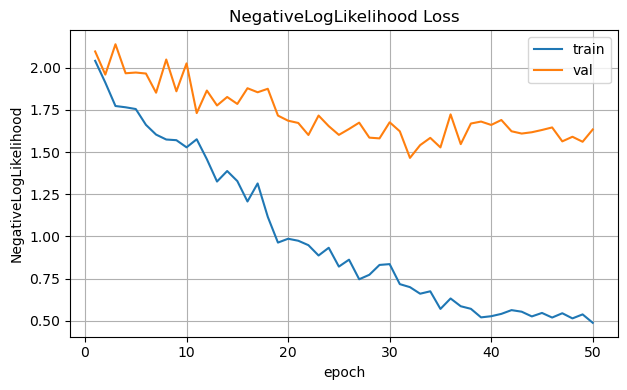

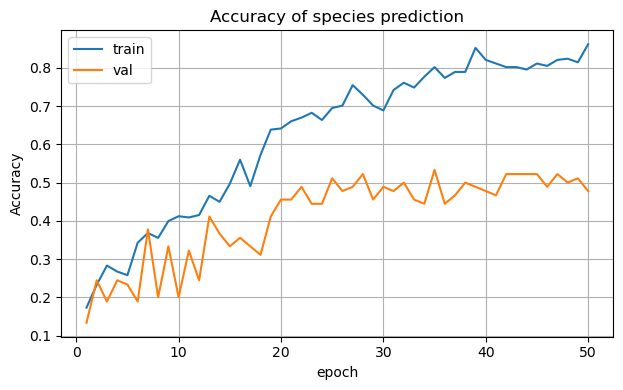

In [25]:
for i in range(len(results_df)):
    row = results_df.iloc[i]
    print(row[:3])
    plot_learning_process(row.train_latin_loss, row.val_latin_loss, "NegativeLogLikelihood Loss")
    plot_learning_process(row.train_latin_acc, row.val_latin_acc, "Accuracy of species prediction")

In [26]:
test_dataset = TreeDatasetFromSubset(test, prepare_transform)
test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False,
)

In [27]:
PATH = f"{target_column}_prediction_model.pt"
assert not os.path.exists(PATH), "There is a checkpoint already! Remove this assert to override"
test_results = test_loop(net, test_dataloader, loss_clf)
torch.save({
    'epoch': epochs,
    'model_state_dict': net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': test_results["val_loss"],
    'acc': test_results["val_acc"]
},
    PATH)

AssertionError: There is a checkpoint already! Remove this assert to override

In [28]:
model = ResNet18(out_channels=8, layer_num=3, fc_clf_hidden=512).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
acc = checkpoint['acc']

model.eval()

TypeError: ResNet18.__init__() got an unexpected keyword argument 'fc_clf_hidden'

In [29]:
from sklearn.metrics import confusion_matrix

In [30]:
preds = []
trues = []
with torch.no_grad():
    for X, y_clf in tqdm(val_dataloader, leave=False, desc="Batch #"):
        torch.cuda.empty_cache()
        gc.collect()
        
        X = X.to(device)
        y_clf = y_clf.to(device)
        pred = net(X).argmax(1)
        preds.extend(pred.tolist())
        trues.extend(y_clf.tolist())

Batch #:   0%|          | 0/45 [00:00<?, ?it/s]

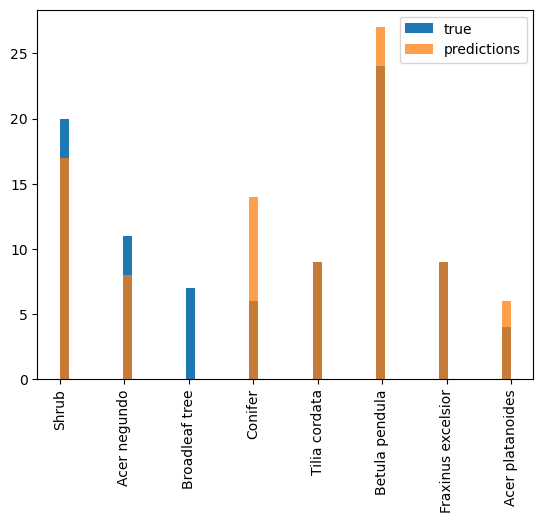

In [31]:
# plt.subplots(1, 2, sharex=True, figsize=(12, 6))
plt.hist(trues, bins=50, label="true")
plt.hist(preds, bins=50, label="predictions", alpha=0.75)
plt.xticks(ticks=range(len(data.label_map)), labels=list(data.label_map.keys()), rotation=90)
plt.legend()
plt.show()

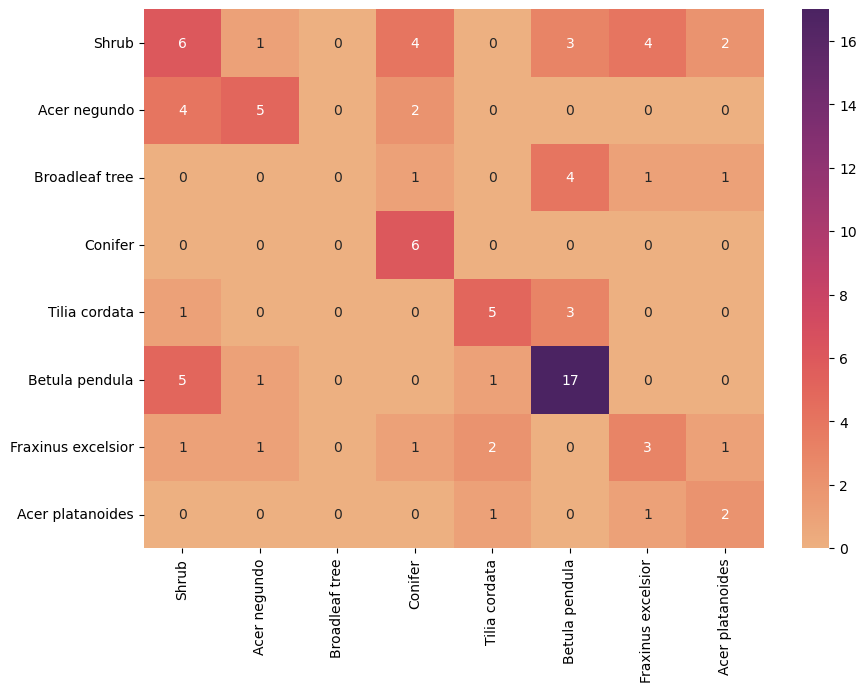

In [32]:
df_cm = pd.DataFrame(confusion_matrix(trues, preds), index=data.label_map.keys(), columns=data.label_map.keys())
plt.figure(figsize = (10, 7))
sns.heatmap(df_cm, cmap="flare", annot=True)
plt.show()